In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:75% !important}</style>"))

# **Project: Decision Trees and Random Forest - Loan Eligibility Prediction**


We will continue our work on the Loan Eligibility Prediction dataset for this project.

----------------
## **Context:** 
----------------

**Credit risk is the risk of financial loss resulting from the failure by a borrower to repay the principal and interest owed to the lender.** The lender uses the interest payments from the loan to compensate for the risk of potential losses. When the borrower defaults on his/her obligations, it causes an interruption in the cash flow of the lender.

In the banking sector, this is an important factor to be considered before approving the loan of an applicant in order to cushion the lender from loss of cash flow and reduce the severity of losses. 

------------------
## **Objective:**
------------------

Easy House is a finance company that deals in several varieties of home loans. They have a presence across urban, semi-urban, and rural areas. Currently the customer first applies for a home loan, after which the company validates the customer's eligibility for that loan. 

Now, the company wants to automate this loan eligibility process. They want to harness their past customers' data to **build a model to predict whether the loan should be approved or not.** This would help the company prevent potential losses, save time and focus more on eligible customers.

--------------------------
## **Data Dictionary:**
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## **Importing the necessary libraries and overview of the dataset**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

#algorithms to use
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn import metrics

#for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## **Loading the data**

In [3]:
data = pd.read_csv("CreditRisk.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360.0,1.0,Urban,1


## **Checking the info of the data**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 62.5+ KB


**Observations:**

- There are **614 observations and 13 columns** in the data.
- ApplicantIncome, CoapplicantIncome, Loan_Amount_Term, Credit_History, and Loan_Status are numeric data types. **The rest of the variables are of the object data type.**
- There are several columns with less than 614 non-null entries i.e. **these columns have missing values.**
- **Loan_ID column is an identifier.** Let's check if each entry of the column is unique.

In [5]:
data.Loan_ID.nunique()

614

- We can see that **all the entries of this column are unique.** Hence, this column would not add any value to our analysis. 
- Let's drop this column.

## **Exploratory Data Analysis and Data Preprocessing**

**Note:** We have explored this data earlier in the project for classification. Here, we will simply look at some basic univariate analysis and data preprocessing and move to the model building section.

## **Dropping the Loan_ID column**

In [6]:
data.drop(columns=['Loan_ID'], inplace=True)

## **Summary Statistics for numerical columns**

In [7]:
#Creating a list of numerical columns
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,614.0,141.166124,88.340630,0.0,98.0,125.0,164.75,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0


**Observations:**

- The average income of applicants is about 5.4K dollars. It has a large range of values from 150 to 81,000. It would be interesting to see if low applicant income implies a low loan amount.
- The average co-applicant income is about 1.6K dollars which is much lower than the applicant's income. The 25th percentile value is 0 and the median value is 1,188 dollars which implies that the number of joint home loans is more than the number of non-joint loans.
- The two columns `ApplicantIncome` and `CoapplicantIncome` give the same information i.e. income of applicants. It would be better to have that information in one column only. We can add these two columns to get the total income per application.
- The 25th, 50th, and 75th percentile value of the loan term is 360 months i.e. 30 years. This implies that the majority of home loans in this dataset are for 30 years of term.
- We can convert the scale of the loan term from months to years to make it easier to read.
- The average loan amount is 1.41K dollars. It has a large range of values, which is to be expected. 
- The loan amount has zero values, which is absurd since loan amounts are meant to be non-zero. So we can treat 0's as missing values.

Before imputing the missing values and 0's in `LoanAmount`, let's do some feature engineering and check the distributions, counts, and outliers for different variables.

## **Feature Engineering**

In [8]:
#Converting the scale of loan term from months to years
data['Loan_Amount_Term'] = data['Loan_Amount_Term']/12

In [9]:
#Adding the applicant and co-applicant income to get the total income per application
data['total_income'] = data['ApplicantIncome'] + data['CoapplicantIncome']

In [10]:
#Dropping the columns as we created a new column which captures the same information
data.drop(columns = ['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

## **Checking the percentage of each category for categorical variables**

In [11]:
#Creating list of categorical columns
cat_col= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Status']

for col in cat_col:
    print(data[col].value_counts(normalize=True))  #The parameter normalize=True gives the percentage of each category
    print('*'*40)                                  #Print the * 40 times to separate different variables

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
****************************************
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
****************************************
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
****************************************
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
****************************************
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
****************************************
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64
****************************************
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
****************************************
1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64
****************************************


**Observations:**

- Percentage of male customers (approx 81%) is more than the percentage of female customers (approx 19%).
- About 65% of customers are married. This indicates that married people apply more for the home loan as compared to non-married people.
- The majority of customers have 0 or 1 dependents. Some of these entries are 3+ which means 3 or more dependents. Since we don't know the actual number, we can treat this as a separate category.
- About 78% of customers are graduate. It looks like the majority of customers are educated.
- Only ~14% of customers are self-employed. This indicates that salaried people apply more for the home loan.
- The majority of customers, about 84%, have credit history as per the required guidelines.
- The count of observations is approximately evenly distributed among Urban, Semi-Urban, and Rural areas. This implies that the company has a presence in all kinds of areas.
- The number of home loans approved is comparatively higher than the number of those not approved. About 69% of applied loans get approved. Although we have limited data, the reason for this could either be a fairly lenient attitude from the company towards approving loans OR that many of the customers applying for these home loans are actually eligible for them.

#### Imputing missing values

In [23]:
#Imputing missing values with mode for the categorical variables 
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    data[col].fillna(value = data[col].mode()[0], inplace = True)

In [24]:
#Replacing 0's with null values in loan amount 
data.LoanAmount.replace(0, np.nan, inplace=True)

#Imputing null values in loan amount with the median
data.LoanAmount.fillna(value = data.LoanAmount.median(), inplace = True)

#### Preparing data for modeling

In [25]:
#Separating target variable and other variables
X = data.drop(columns = 'Loan_Status')
Y = data['Loan_Status']

In [26]:
#Creating dummy variables 
#drop_first=True is used to avoid redundant variables
X = pd.get_dummies(X, drop_first=True)

In [27]:
#Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 7)

Now that we are done with the data preprocessing. Let's move onto the model building section.

## **Building Classification Models**

**Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

### Model evaluation criterion:

#### Since this is a binary classification problem, the model can make wrong predictions in one of two ways:
1. Predicting a customer is not eligible for a loan when the customer actually is eligible - **Loss of opportunity**
2. Predicting a customer is eligible for a loan when the customer is actually not - **Financial Loss**

#### Which case is more important? 
* **Predicting that the customer is eligible when he is not**, because the person might default or not be able to return the loan, which would result in financial loss to the company.

#### How to reduce this loss i.e need to reduce False Negatives?
* In classification, the class of interest is considered the positive class. Here, the class of interest is 0 i.e. identifying non-eligible customers. So, the company wants to minimize the number of false negatives, in other words **Recall** is the evaluation criterion to be maximized.

### Note
- We have already seen the classification performance earlier using Logistic Regression and the KNN classifier.
- Here, **we will aim to get better recall for class 0** as the company would want the model to correctly identify as many of the 'non-eligible' customers as possible.

Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [28]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## **Decision Tree**

In this section we will implement a decision tree classifier on the data.


In [34]:
#Fitting the decision tree classifier on the training data
d_tree = DecisionTreeClassifier(class_weight = {0:0.7, 1:0.3}, random_state = 7)

d_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.7, 1: 0.3}, random_state=7)

**Let's check the performance on the training data:**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



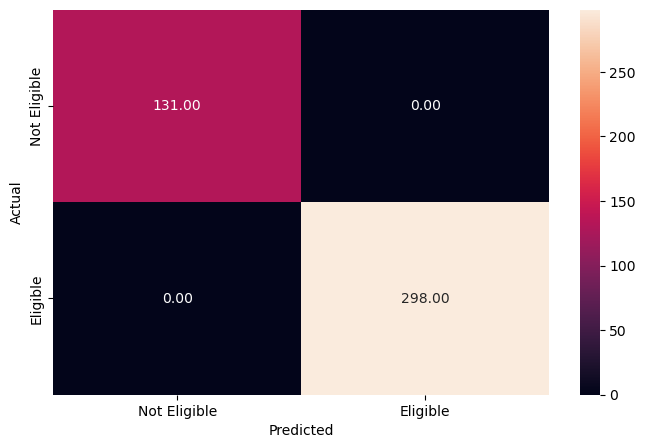

In [35]:
#Checking performance on the training data
y_pred_train1 = d_tree.predict(X_train)
metrics_score(y_train, y_pred_train1)

**Observations:_____________**
- The decision tree appears to be overfitting the data. Let's validate with the testing data if indeed it is overfitting

**Let's check the performance of the model on the testing data:**

              precision    recall  f1-score   support

           0       0.57      0.64      0.60        61
           1       0.81      0.76      0.78       124

    accuracy                           0.72       185
   macro avg       0.69      0.70      0.69       185
weighted avg       0.73      0.72      0.72       185



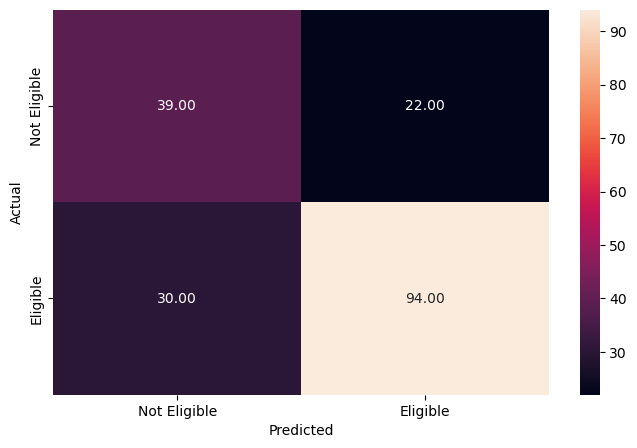

In [36]:
#Checking performance on the testing data
y_pred_test1 = d_tree.predict(X_test)
metrics_score(y_test, y_pred_test1)

**Observations:_____________**
- As suspected the decision trees is overfitting. We can see that the precision and recall for class 0 have dropped significantly hence, this model is not suitable for predicting the eligibility of customers as it will not give us accurate eligibility predictions. 

**Let's try hyperparameter tuning using GridSearchCV to find the optimal max_depth** in order to reduce overfitting of the model. We can tune some other hyperparameters as well.

## **Decision Tree - Hyperparameter Tuning**

We will use the class_weight hyperaparameter with value equal to {0:0.7, 1:0.3} which is approximately the opposite of the imbalance in the original data. 

**This would tell the model that 0 is the important class here.**

In [37]:
# Choose the type of classifier 
d_tree_tuned = DecisionTreeClassifier(random_state = 7, class_weight = {0:0.7, 1:0.3})

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,10), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations - recall score for class 0
scorer = metrics.make_scorer(recall_score, pos_label = 0)

# Run the grid search
grid_obj = GridSearchCV(d_tree_tuned, parameters, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
d_tree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
d_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.7, 1: 0.3}, criterion='entropy',
                       max_depth=7, min_samples_leaf=20, random_state=7)

We have tuned the model. Now, **let's fit the tuned model on the training data** and check the model performance on the training and testing data.

              precision    recall  f1-score   support

           0       0.57      0.79      0.66       131
           1       0.89      0.74      0.81       298

    accuracy                           0.75       429
   macro avg       0.73      0.76      0.73       429
weighted avg       0.79      0.75      0.76       429



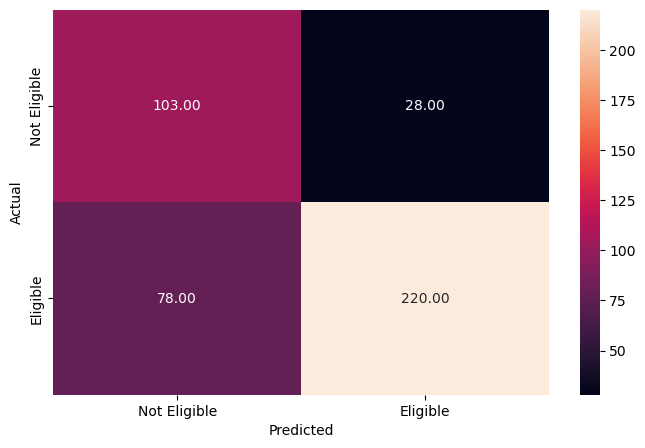

In [39]:
#Checking performance on the training data
y_pred_train2 = d_tree_tuned.predict(X_train)
metrics_score(y_train, y_pred_train2)

**Observations:_____________**
- The performance of the model on the testing has dropped indicating that he model is no longer overfitting. 
- The precision value for class 1 is lesser than all the over values and hence this model will not accurately predict the eligibility of customers.

**Let's check the model performance on the testing data**

              precision    recall  f1-score   support

           0       0.51      0.61      0.56        61
           1       0.79      0.72      0.75       124

    accuracy                           0.68       185
   macro avg       0.65      0.66      0.65       185
weighted avg       0.70      0.68      0.69       185



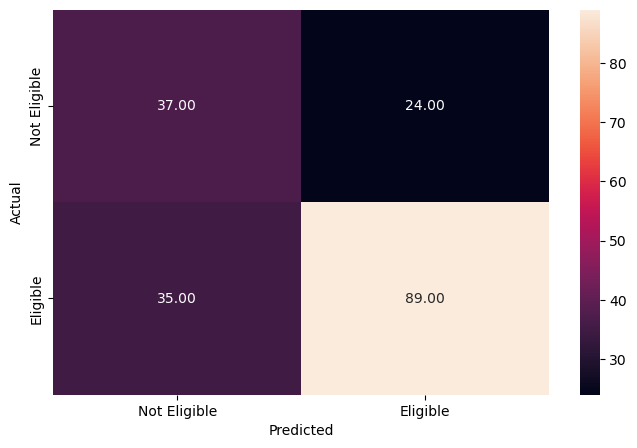

In [40]:
#Checking performance on the testing data
y_pred_test2 = d_tree_tuned.predict(X_test)
metrics_score(y_test, y_pred_test2)

**Observations:_____________**
- The precision and recall values for the testing data has not much improved from the values given on the training data.
- Even with the turned parameters this model is not optimal for predict the eligible customer from the non eligible customers

**Let's visualize the tuned decision tree** and observe the decision rules:

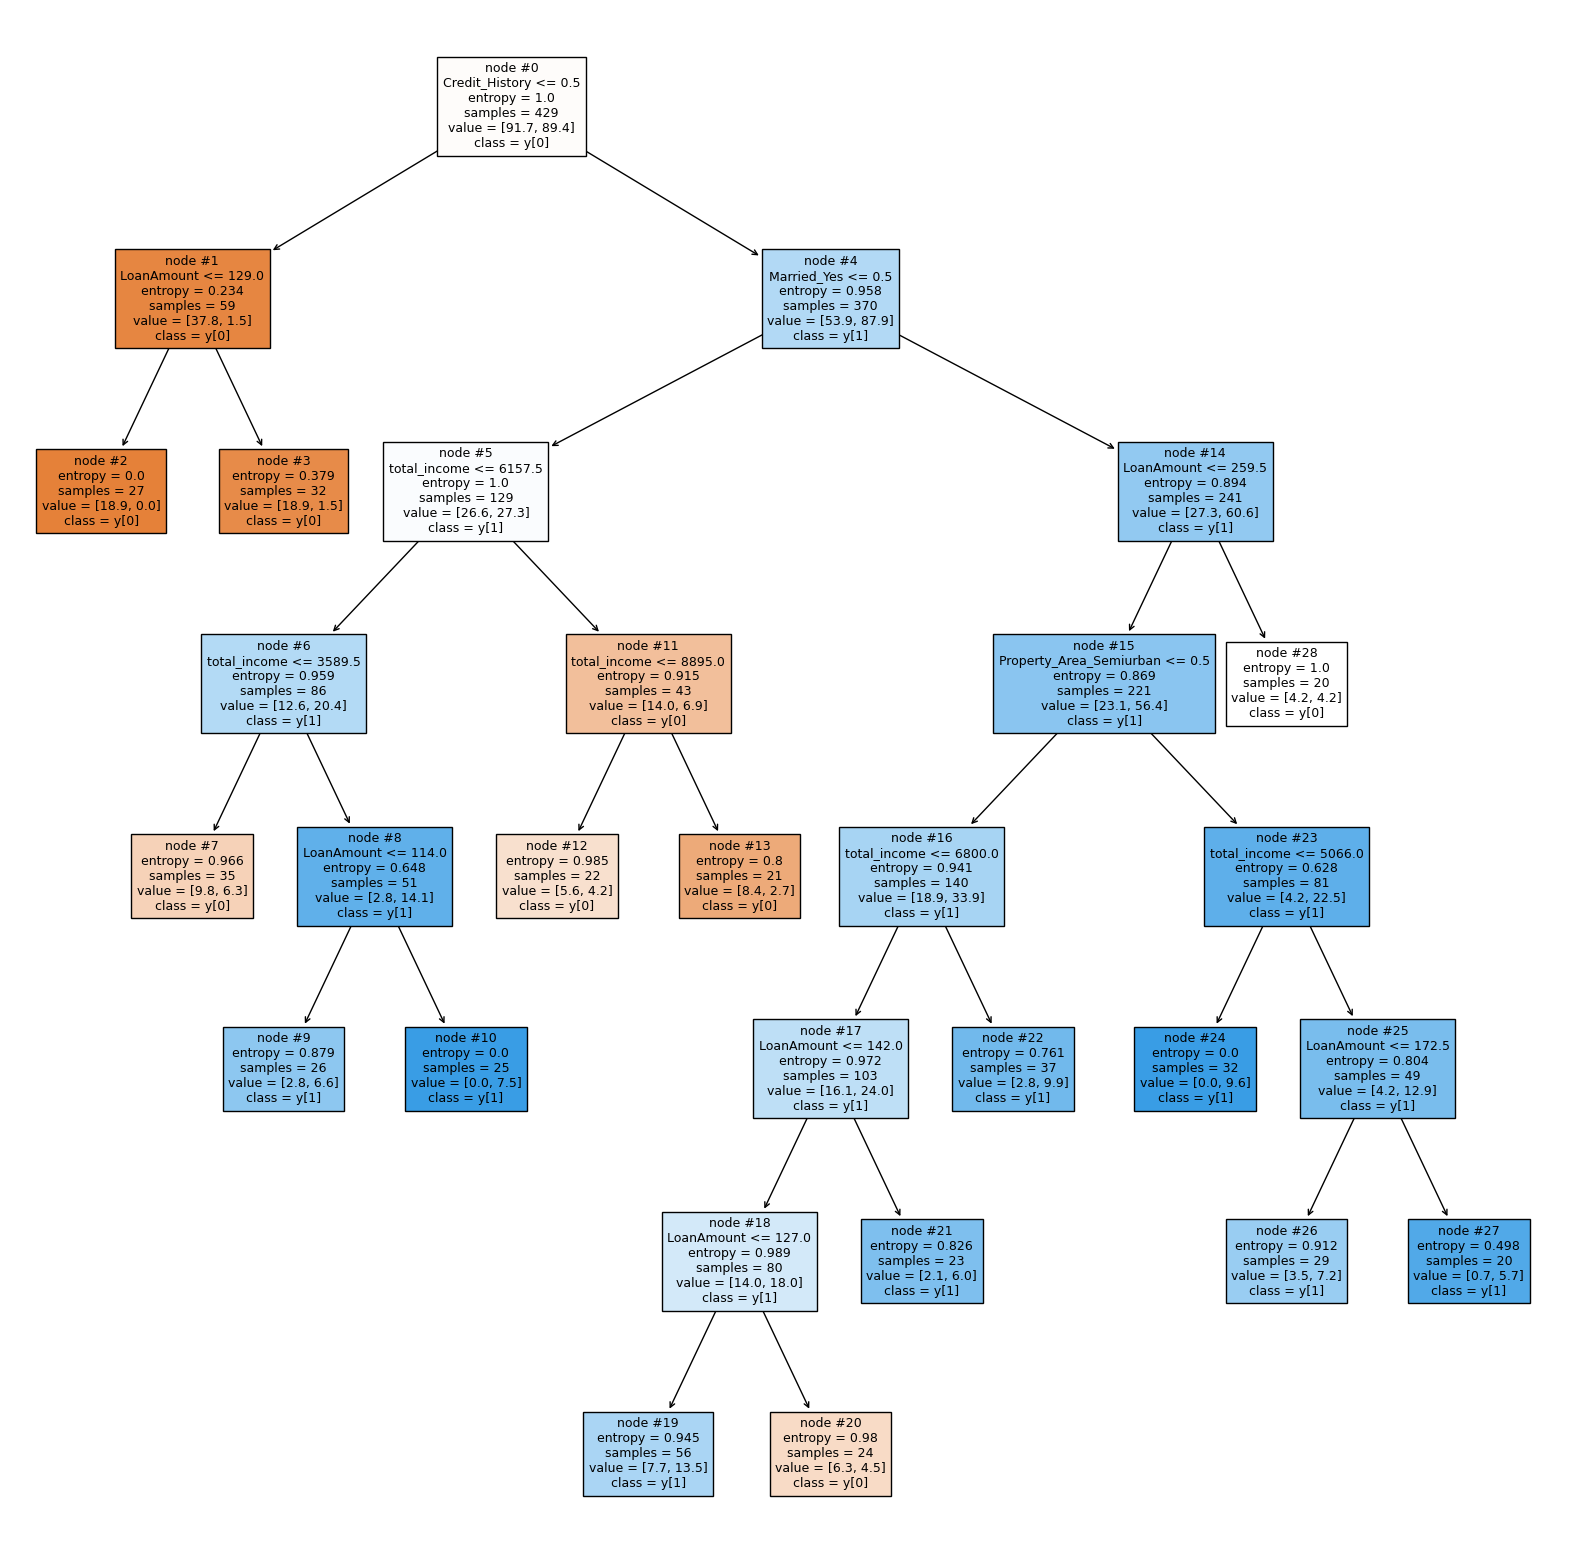

In [41]:
features = list(X.columns)

plt.figure(figsize=(20,20))

tree.plot_tree(d_tree_tuned, feature_names = features ,filled = True, fontsize = 9, node_ids = True, class_names = True)
plt.show()

**Observations:_____________**
- From the decision tree we can see that the most important factor for eligibility is credit history. For customers with a 'credit history <= 0.5' and 'loan amount <= 129' they are likely not to get the loan. Conversely, customers with a bad credit history and 'loan amount >= 129' are also likely not to get the loan.
- For customers with good credit history, who are married and have a total income of less than 3689.5 are likely not to be eligible for a loan.
- Customers with good credit history, who are married with a total income of greater than 6157 but less than 8895 are also likely to not be considered for a loan.
- Customers with a good credit score, who are not married, and are applying for a loan less than 259.5, with a property located outside a semi-urban area and have a total monthly income less than 6800, and request a loan amount of less than 127, are likely to be eligibel for a loan. Whereas, customers with greater than 6800 are likely go be considered eligible.
- Customers with a good credit score, who are not married, and are applying for a loan less than 259.5, with a property located within a semi-urban area with a total income greater than 5066 and a loan request greater than or less than or equal to 172.5 are likely to be considered for the loan
- Customers with good credit history who are not married and requesting a loan amount greater than 259.5 are not likely to be eligible. 
- From the decision tree we can see that total income, loan amount, married status and property area are of the most important factors considered for loan eligibility.

**Let's look at the feature importance** of the tuned decision tree model:

In [42]:
# importance of features in the tree building

print (pd.DataFrame(d_tree_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                              Imp
Credit_History           0.574778
total_income             0.206104
LoanAmount               0.122203
Married_Yes              0.054235
Property_Area_Semiurban  0.042681
Loan_Amount_Term         0.000000
Gender_Male              0.000000
Dependents_1             0.000000
Dependents_2             0.000000
Dependents_3+            0.000000
Education_Not Graduate   0.000000
Self_Employed_Yes        0.000000
Property_Area_Urban      0.000000


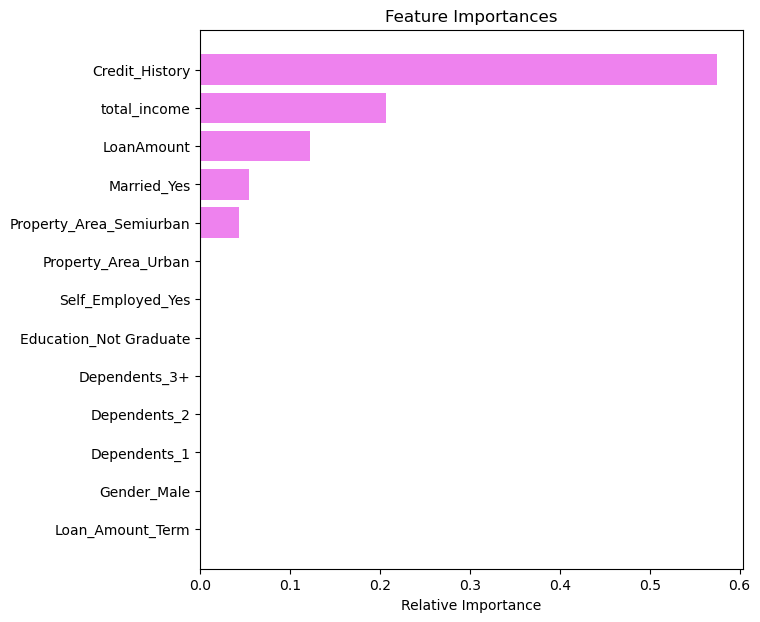

In [44]:
#Plotting the feature importance
importances = d_tree_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(7,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- **As observed earlier, credit history is the most important feature** **followed by total income and loan amount** which makes sense.
- **Married_Yes and Property_Area_Semiurban have some importance** and the rest of the variables have no impact in this model, while deciding loan eligibility.

Now let's build another model - **a random forest classifier**

## **Random Forest Classifier**

- **Fitting the random forest classifier on the training data**
- **Checking the performance on both training and testing data**

In [46]:
#Fitting the decision tree classifier on the training data
rf_estimator = RandomForestClassifier(class_weight={0:0.70, 1:0.30}, random_state = 7)

rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.7, 1: 0.3}, random_state=7)

**Let's check the performance of the model on the training data:**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



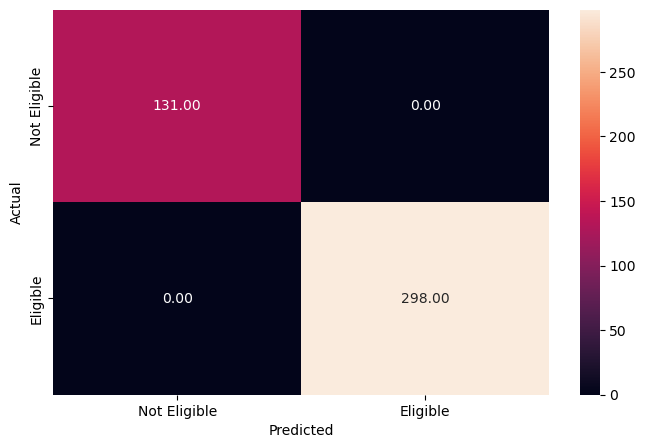

In [47]:
#Checking performance on the training data
y_pred_train3 = rf_estimator.predict(X_train)
metrics_score(y_train, y_pred_train3)

**Observations:_____________**
- Random forest is giving good predictions for all metrics. Let's predict the test data and determine if the model is overfitting.

**Let's confirm this by checking its performance on the testing data:**

              precision    recall  f1-score   support

           0       0.81      0.49      0.61        61
           1       0.79      0.94      0.86       124

    accuracy                           0.79       185
   macro avg       0.80      0.72      0.74       185
weighted avg       0.80      0.79      0.78       185



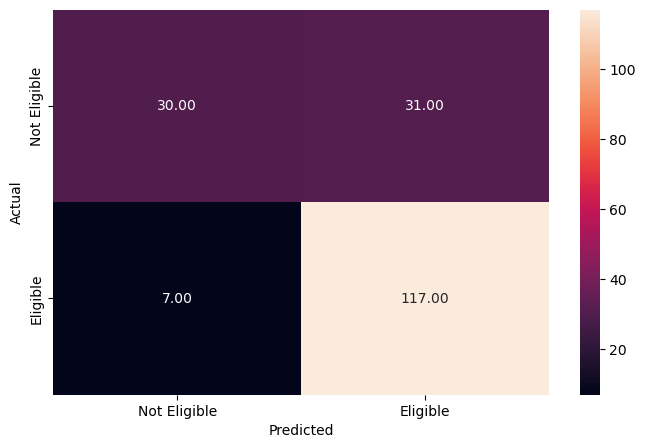

In [49]:
#Checking performance on the testing data
y_pred_test3 = rf_estimator.predict(X_test)
metrics_score(y_test, y_pred_test3)

**Observations:_____________**
- As suspected the random forest was indeed overfitting the training data as the performance of the test data is notably lesser.

 **Let's see if we can get a better model by tuning the random forest classifier:**

## **Random Forest Classifier - Hyperparameter Tuning**

Let's try **tuning some of the important hyperparameters of the Random Forest Classifier**. 

We will **not** tune the `criterion` hyperparameter as we know from hyperparameter tuning for decision trees that `entropy` is a better splitting criterion for this data.

In [50]:
# Choose the type of classifier. 
rf_estimator_tuned = RandomForestClassifier(criterion="entropy", random_state = 7)

# Grid of parameters to choose from
parameters = {"n_estimators": [100, 110, 120],
    "max_depth": [5, 6, 7],
    "max_features": [0.8, 0.9, 1]
             }

# Type of scoring used to compare parameter combinations - recall score for class 0
scorer = metrics.make_scorer(recall_score, pos_label = 0)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

In [51]:
#Fitting the best algorithm to the training data
rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features=0.9,
                       n_estimators=110, random_state=7)

              precision    recall  f1-score   support

           0       0.98      0.48      0.65       131
           1       0.81      1.00      0.90       298

    accuracy                           0.84       429
   macro avg       0.90      0.74      0.77       429
weighted avg       0.87      0.84      0.82       429



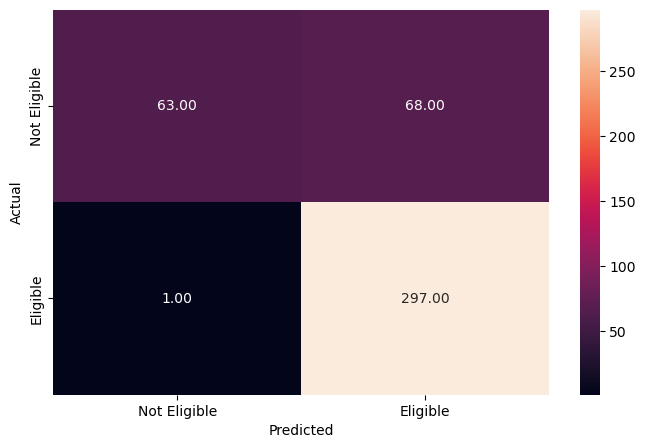

In [52]:
#Checking performance on the training data
y_pred_train4 = rf_estimator_tuned.predict(X_train)
metrics_score(y_train, y_pred_train4)

- We can see that after hyperparameter tuning, the model is performing poorly on the train data as well.
- We can try adding some other hyperparameters and/or changing values of some hyperparameters to tune the model and see if we can get a better performance.

**Note:** **GridSearchCV can take a long time to run** depending on the number of hyperparameters and the number of values tried for each hyperparameter. **Therefore, we have reduced the number of values passed to each hyperparameter.** 

- **Tuning the random forest classifier using GridSearchCV**
- **Checking the performance on both training and testing data**
- **Comparing the results with the results from the random forest model with default parameters**

In [53]:
# Choose the type of classifier. 
rf_estimator_tuned = RandomForestClassifier(criterion = "entropy", random_state = 7)

# Grid of parameters to choose from
parameters = {"n_estimators": [110, 120],
    "max_depth": [6, 7],
    "min_samples_leaf": [20, 25],
    "max_features": [0.8, 0.9],
    "max_samples": [0.9, 1],
    "class_weight": [{0:0.7, 1:0.3}, "balanced", {0:0.4, 1:0.1}]
             }

# Type of scoring used to compare parameter combinations - recall score for class 0
scorer = metrics.make_scorer(recall_score, pos_label=0)

# Run the grid search on the training data using scorer=scorer and cv=5
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

# Save the best estimator to variable rf_estimator_tuned
rf_estimator_tuned = grid_obj.best_estimator_

#Fit the best algorithm to the training data
rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.4, 1: 0.1}, criterion='entropy',
                       max_depth=6, max_features=0.8, max_samples=0.9,
                       min_samples_leaf=25, n_estimators=120, random_state=7)

**Let's check the performance of the tuned model:**

              precision    recall  f1-score   support

           0       0.52      0.85      0.65       131
           1       0.91      0.65      0.76       298

    accuracy                           0.71       429
   macro avg       0.71      0.75      0.70       429
weighted avg       0.79      0.71      0.72       429



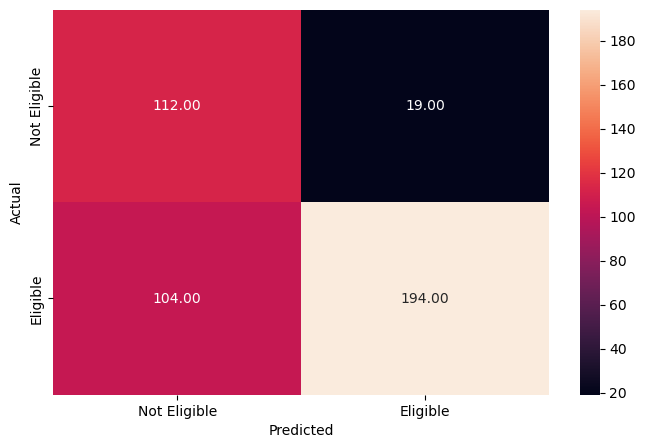

In [54]:
#Checking performance on the training data
y_pred_train5 = rf_estimator_tuned.predict(X_train)
metrics_score(y_train, y_pred_train5)

**Observations:_____________**
- We can see a drop in the precision in class 0, subsequently there is an increase in recall in that same class which is the metric we are most interested in 
- In class 1 there is a noticeable decrease in recall

**Let's check the model performance on the test data:**

              precision    recall  f1-score   support

           0       0.50      0.70      0.59        61
           1       0.82      0.65      0.73       124

    accuracy                           0.67       185
   macro avg       0.66      0.68      0.66       185
weighted avg       0.71      0.67      0.68       185



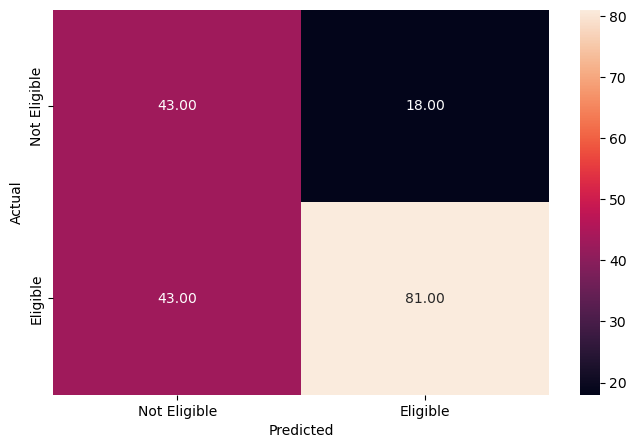

In [57]:
#Checking performance on the testing data
y_pred_test5 = rf_estimator_tuned.predict(X_test)
metrics_score(y_test, y_pred_test5)

**Observations:_____________**
- As with the training data there is a drop in recall for class 1 and a drop in precision in class 0.
- For the class of interest (class 0) there in an increase in recall
- Hence this model would be better at predicting True positives (those who are not eligible) and therefore lowering the risk of loaning to ineligible customers.

**One of the drawbacks of ensemble models is that we lose the ability to obtain an interpretation of the model. We cannot observe the decision rules for random forests the way we did for decision trees. So, let's just check the feature importances of the model.**

### **Observations** 


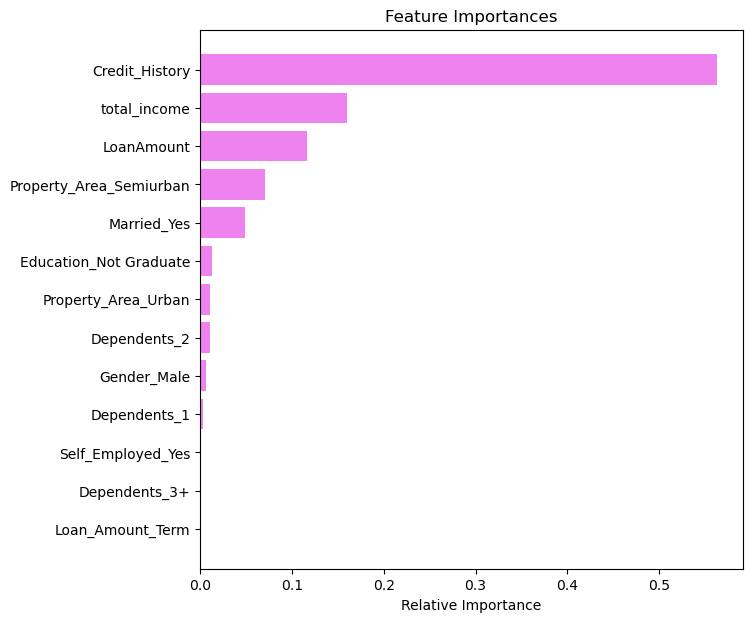

In [59]:
importances = rf_estimator_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(7,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Observations:_____________**
- The most important features that random forest uses to predict eligibility are credit history, total income, loan amount, property area, and married status
- Features like education level, dependent and gender also have some level of importance though not a prevalent as the former list
- The feature loan amount term seem to carry little to no importance at all

## **Conclusion and Recommendations**

**Conclusions___________:**
- The best model we have got so far is the tuned random forest model which is giving nearly 70% recall on the test data .
- The company should use this model to know beforehand which customer likely to be ineligible for a loan and therefore avoid further risks. 
- Credit history, total income, loan amount, property area and married status seem to be the most important features in making predictions.

**Recommendations____________:**
- A customer's credit history is the most important deciding factor on eligibility. As the decision tree has shown if a customer has a bad credit history it is very unlikely that they would be eligible for loans despite other criteria.
- Many of the customers who apply for this loan are married and hence total income is also very important in deciding eligibility. A higher income is favored over a lesser income as it is likely that those with higher incomes will not default on their loans.
- Of all the areas it appears semi-urban area is the area mostly taken into consideration in the loan eligibility process. It could be that the population that comes for that area has a higher likelihood of loan repayment or they stand out in some particular way (we do not have enough data to pin point what exactly the factor is)
- For loan amount customers with a higher total income are likely to get approval for higher loans that customers with lower total income.
- For customers who are self employed or employees, the consideration for this group is not as important meaning such customers are evaluated on some other basis